[[ 0. 11.  9. 26. 22. 24.]
 [11.  0. 11. 25. 21. 41.]
 [ 9. 11.  0. 12. 14. 23.]
 [26. 25. 12.  0. 44. 20.]
 [22. 21. 14. 44.  0. 18.]
 [24. 41. 23. 20. 18.  0.]]
Shortest Path: ([(0, 2), (2, 3), (3, 5), (5, 4), (4, 1), (1, 0)], 91.0)


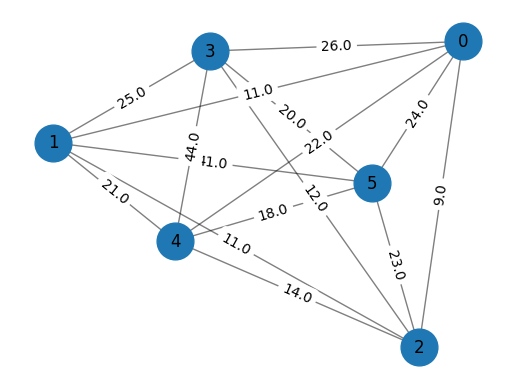

MovieWriter Pillow unavailable; using Pillow instead.


In [283]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class AntColony(object):

    def __init__(self, num_cities, num_ants, num_best):
        """
        Args:
        num_best (int): Number of best ants who deposit pheromone
        """
        self.distances_matrix = self.generate_distances(num_cities)
        self.pheromone_matrix = np.array([0.01]*num_cities*num_cities).reshape(num_cities, num_cities)
        self.cities = np.arange(num_cities)
        self.num_ants = num_ants
        self.num_best = num_best
        # fixed values
        self.num_iterations = 50
        self.evaporation_rate = 0.8
        self.alpha = 0.1
        self.beta = 1.0
        print(self.distances_matrix)
        
    def generate_distances(self, num_cities):
        distance = np.zeros((num_cities, num_cities))
        for i in range(num_cities):
            for j in range(i+1, num_cities):
                distance[i][j] = distance[j][i] = np.random.randint(4,50)
        return distance 
        
    def run(self):
        shortest_path = None
        best_path_so_far = ("", np.inf)
        for i in range(self.num_iterations):
            all_paths = self.generate_all_paths()
            self.spread_pheromone(all_paths)
            shortest_path = min(all_paths, key=lambda x: x[1])
            if shortest_path[1] < best_path_so_far[1]:
                best_path_so_far = shortest_path 
            self.pheromone_matrix *= self.evaporation_rate 
        return best_path_so_far

    def spread_pheromone(self, all_paths):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:self.num_best]:
            for move in path:
                self.pheromone_matrix[move[0], move[1]] += 1.0 / self.distances_matrix[move[0], move[1]]

    def calculate_path_distance(self, path):
        total_distance = 0
        for ele in path:
            total_distance += self.distances_matrix[ele[0], ele[1]]
        return total_distance

    def generate_all_paths(self):
        all_paths = []
        for i in range(self.num_ants):
            path = self.generate_path(0)
            all_paths.append((path, self.calculate_path_distance(path)))
        return all_paths

    def generate_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances_matrix) - 1):
            move = self.select_next_move(self.pheromone_matrix[prev], self.distances_matrix[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started
        return path

    def select_next_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        indices = np.where(pheromone != 0)[0]
        row = (pheromone[indices] ** self.alpha) * ((1.0 / dist[indices]) ** self.beta)

        norm_row = row / row.sum()
        next_move = np.random.choice(indices, 1, p=norm_row)[0]
        return next_move
    def plot_graph(self):
        G = nx.Graph()
        for i in range(len(self.distances_matrix)):
            for j in range(i + 1, len(self.distances_matrix)):
                G.add_edge(i, j, weight=self.distances_matrix[i, j])

        pos = nx.spring_layout(G)  # positions for all nodes

        # nodes
        nx.draw_networkx_nodes(G, pos, node_size=700)

        # edges
        nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

        # labels
        nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")

        # edge labels
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        plt.axis("off")
        plt.show()

    def shortest_path_simulation(self, shortest_path):
        G = nx.Graph()
        for i in range(len(self.distances_matrix)):
            for j in range(i + 1, len(self.distances_matrix)):
                G.add_edge(i, j, weight=self.distances_matrix[i, j])

        pos = nx.spring_layout(G)  # positions for all nodes

        # Draw the graph with the shortest path highlighted
        plt.figure(figsize=(8, 6))
        nx.draw(G, pos, with_labels=True, node_size=600)
        shortest_path_edges = [(shortest_path[i], shortest_path[i + 1]) for i in range(len(shortest_path) - 1)]
        shortest_path_edges.append((shortest_path[0], shortest_path[-1]))
        nx.draw_networkx_edges(G, pos, edgelist=shortest_path_edges, width=2.0, edge_color='purple')

        # Draw edge labels for the shortest path
        edge_labels = {(i, j): G[i][j]['weight'] for i, j in G.edges() if (i, j) in shortest_path_edges or (j, i) in shortest_path_edges}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        # Draw the initial position of the circle
        circle = plt.Circle(pos[shortest_path[0]], 0.09, color='black')
        plt.gca().add_patch(circle)

        # Function to update the position of the circle
        def update(frame):
            circle.center = pos[shortest_path[frame]]

        # Create animation
        num_frames = len(shortest_path)
        anim = FuncAnimation(plt.gcf(), update, frames=num_frames, repeat=False)

        # Save animation as a GIF
        anim.save('animation.gif', writer='Pillow', fps=2)

        plt.close()

        

num_cities = 6
num_ants = 5
num_best = 4

ant_colony = AntColony(num_cities, num_ants, num_best)
shortest_path = ant_colony.run()
print("Shortest Path:", shortest_path)
ant_colony.plot_graph()
ant_colony.shortest_path_simulation([node for node, _ in shortest_path[0]])
